In [2]:
!pip install conllu

In [3]:
def convert_conllu_to_training_data(conllu_file_path):
    training_data = []
    current_sentence = []
    current_tags = []

    with open(conllu_file_path, 'r') as file:
        for line in file:
            if line.strip() == "":  
                if current_sentence and current_tags:
                    training_data.append((current_sentence, current_tags))
                    current_sentence = []
                    current_tags = []
            else:
                parts = line.split('\t')
                if len(parts) > 3:  
                    form = parts[1]
                    upos = parts[3]
                    current_sentence.append(form)
                    current_tags.append(upos)

    if current_sentence and current_tags:
        training_data.append((current_sentence, current_tags))

    return training_data


training_data = convert_conllu_to_training_data('en_atis-ud-train.conllu')
print(training_data[:5])

[(['what', 'is', 'the', 'cost', 'of', 'a', 'round', 'trip', 'flight', 'from', 'pittsburgh', 'to', 'atlanta', 'beginning', 'on', 'april', 'twenty', 'fifth', 'and', 'returning', 'on', 'may', 'sixth'], ['PRON', 'AUX', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'PROPN', 'ADP', 'PROPN', 'VERB', 'ADP', 'NOUN', 'NUM', 'ADJ', 'CCONJ', 'VERB', 'ADP', 'NOUN', 'ADJ']), (['now', 'i', 'need', 'a', 'flight', 'leaving', 'fort', 'worth', 'and', 'arriving', 'in', 'denver', 'no', 'later', 'than', '2', 'pm', 'next', 'monday'], ['ADV', 'PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'CCONJ', 'VERB', 'ADP', 'PROPN', 'DET', 'ADJ', 'ADP', 'NUM', 'NOUN', 'ADJ', 'NOUN']), (['i', 'need', 'to', 'fly', 'from', 'kansas', 'city', 'to', 'chicago', 'leaving', 'next', 'wednesday', 'and', 'returning', 'the', 'following', 'day'], ['PRON', 'VERB', 'PART', 'VERB', 'ADP', 'PROPN', 'PROPN', 'ADP', 'PROPN', 'VERB', 'ADJ', 'NOUN', 'CCONJ', 'VERB', 'DET', 'VERB', 'NOUN']), (['what', 'is', 'the', 'mean

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def load_conllu_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = []
        sentence = []
        tags = []
        for line in file:
            if line.strip() == "":
                if sentence and tags:
                    data.append((sentence, tags))
                    sentence = []
                    tags = []
            elif not line.startswith("#"):  
                parts = line.split('\t')
                if len(parts) > 3:
                    word = parts[1]
                    tag = parts[3]
                    sentence.append(word)
                    tags.append(tag)
        if sentence and tags:
            data.append((sentence, tags))
    return data

train_path = 'en_atis-ud-train.conllu' 
dev_path = 'en_atis-ud-dev.conllu' 
test_path = 'en_atis-ud-test.conllu' 
training_data = load_conllu_data(train_path)
dev_data = load_conllu_data(dev_path)
test_data = load_conllu_data(test_path)



tag_to_ix = {'<PAD>': 0, 'CCONJ': 1, 'NOUN': 2, 'AUX': 3, 'PRON': 4, 'DET': 5, 'ADP': 6, 'NUM': 7, 'ADJ': 8, 'ADV': 9, 'PART': 10, 'PROPN': 11, 'INTJ': 12, 'VERB': 13, '<UNK>': 14, 'SYM': 15}
idx_to_tag = {idx: tag for tag, idx in tag_to_ix.items()}





In [5]:
from collections import Counter

def build_vocab(train_data, dev_data):
    word_counts = Counter()

    for sentence, _ in train_data + dev_data:
        word_counts.update(sentence)

    unk_count = 0
    for word, count in list(word_counts.items()):
        if count < 3:
            unk_count += count
            del word_counts[word]

    word_counts['<UNK>'] = unk_count

    word_to_ix = {word: idx for idx, word in enumerate(word_counts)}

    return word_to_ix, word_counts

word_to_ix, word_counts = build_vocab(training_data, dev_data)

training_data_modified = []
for sentence, tags in training_data:
    modified_sentence = [word if word_counts[word] >= 3 else '<UNK>' for word in sentence]
    training_data_modified.append((modified_sentence, tags))

# Replace infrequent words in dev data
dev_data_modified = []
for sentence, tags in dev_data:
    modified_sentence = [word if word_counts[word] >= 3 else '<UNK>' for word in sentence]
    dev_data_modified.append((modified_sentence, tags))


In [ ]:
#Unidirectional LSTM
# EMBEDDING_DIM = 100
# HIDDEN_DIM = 128

# class LSTMTagger(nn.Module):
#     def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
#         super(LSTMTagger, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim)
#         self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

#     def forward(self, sentence):
#         embeds = self.word_embeddings(sentence)
#         lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
#         tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
#         tag_scores = F.log_softmax(tag_space, dim=1)
#         return tag_scores

# model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
# loss_function = nn.NLLLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1)


In [6]:
import torch.nn.functional as F

EMBEDDING_DIM = 100
HIDDEN_DIM = 128


class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)  
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [7]:
dev_predicted_all = []
dev_targets_all = []
# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for sentence, tags in training_data_modified:
        model.zero_grad()
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
        tag_scores = model(sentence_in)
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(tag_scores, 1)
        correct += (predicted == targets).sum().item()
        total += len(targets)

    train_accuracy = correct / total
    avg_loss = total_loss / len(training_data_modified)

    # Calculate dev accuracy
    model.eval()
    dev_correct = 0
    dev_total = 0
    with torch.no_grad():
        for dev_sentence, dev_tags in dev_data_modified:
            dev_inputs = prepare_sequence(dev_sentence, word_to_ix)
            dev_targets = prepare_sequence(dev_tags, tag_to_ix)
            dev_tag_scores = model(dev_inputs)
            _, dev_predicted = torch.max(dev_tag_scores, 1)
            dev_predicted_all.extend(dev_predicted.tolist())
            dev_targets_all.extend(dev_targets.tolist())
            dev_correct += (dev_predicted == dev_targets).sum().item()
            dev_total += len(dev_targets)

    dev_accuracy = dev_correct / dev_total

    print(f'Epoch {epoch+1}/{10}, Train Loss: {avg_loss}, Train Accuracy: {train_accuracy}, Dev Accuracy: {dev_accuracy}')



Epoch 1/10, Train Loss: 0.2780532338953516, Train Accuracy: 0.9174185592436543, Dev Accuracy: 0.9488260084286574
Epoch 2/10, Train Loss: 0.07119044700782462, Train Accuracy: 0.9781728496557394, Dev Accuracy: 0.9667369054786273
Epoch 3/10, Train Loss: 0.046745421300461686, Train Accuracy: 0.9850580618641455, Dev Accuracy: 0.9718543046357616
Epoch 4/10, Train Loss: 0.037084730532962275, Train Accuracy: 0.9877299352584523, Dev Accuracy: 0.9726068633353402
Epoch 5/10, Train Loss: 0.03147497240751507, Train Accuracy: 0.9890658719556058, Dev Accuracy: 0.9730583985550872
Epoch 6/10, Train Loss: 0.027547153190153082, Train Accuracy: 0.9901962799301203, Dev Accuracy: 0.9729078868151716
Epoch 7/10, Train Loss: 0.024587231146469015, Train Accuracy: 0.9911006063097317, Dev Accuracy: 0.9727573750752558
Epoch 8/10, Train Loss: 0.022128959142358916, Train Accuracy: 0.9917994039667043, Dev Accuracy: 0.9735099337748344
Epoch 9/10, Train Loss: 0.020056776656632434, Train Accuracy: 0.9926626246017881, De

In [8]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for test_sentence, test_tags in test_data:
        test_sentence = [word if word in word_to_ix else '<UNK>' for word in test_sentence]
        test_inputs = prepare_sequence(test_sentence, word_to_ix)
        test_targets = prepare_sequence(test_tags, tag_to_ix)
        test_tag_scores = model(test_inputs)
        _, test_predicted = torch.max(test_tag_scores, 1)
        test_correct += (test_predicted == test_targets).sum().item()
    
        test_total += len(test_targets)
test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.9756838905775076


In [9]:
import torch
# word_to_ix = {'<UNK>': 0, 'An': 1, 'apple': 2, 'a': 3, 'day': 4, 'keeps': 5, 'the': 6, 'doctor': 7, 'away': 8}

def prepare_sequencei(seq, to_ix):
    idxs = [to_ix.get(w, to_ix['<UNK>']) for w in seq]  
    return torch.tensor(idxs, dtype=torch.long)

# sentence = ['an', 'apple', 'a', 'day', 'keeps', 'the', 'doctor', 'away']
input_sent = "an apple a day keeps the doctor away"
sentence = input_sent.lower().split()
sentence_in = prepare_sequencei(sentence, word_to_ix)

model.eval()
with torch.no_grad():
    tag_scores = model(sentence_in)

_, predicted_tags_idx = torch.max(tag_scores, 1)

predicted_tags = [idx_to_tag[idx.item()] for idx in predicted_tags_idx]

print("Predicted POS Tags:", predicted_tags)


Predicted POS Tags: ['DET', 'VERB', 'DET', 'NOUN', 'NOUN', 'DET', 'NOUN', 'NOUN']


In [10]:
# Save the model
torch.save(model.state_dict(), 'LSTM_model.pth')


In [ ]:
import itertools

class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, activation_function):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)
        self.activation = activation_function

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

def calculate_test_accuracy(model, test_data, word_to_ix, tag_to_ix):
    correct = 0
    total = 0
    with torch.no_grad():
        for test_sentence, test_tags in test_data:
            test_sentence = [word if word in word_to_ix else '<UNK>' for word in test_sentence]
            test_inputs = prepare_sequence(test_sentence, word_to_ix)
            test_targets = prepare_sequence(test_tags, tag_to_ix)
            test_tag_scores = model(test_inputs)
            _, test_predicted = torch.max(test_tag_scores, 1)
            correct += (test_predicted == test_targets).sum().item()
            total += len(test_targets)
    test_accuracy = correct / total
    return test_accuracy

embedding_dims = [100, 200]
hidden_dims = [128, 256, 512]
activation_functions = [F.relu, torch.tanh]

results = []

for embedding_dim, hidden_dim, activation_function in itertools.product(embedding_dims, hidden_dims, activation_functions):
    model = LSTMTagger(embedding_dim, hidden_dim, len(word_to_ix), len(tag_to_ix), activation_function)
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    print(f"Training configuration: embedding_dim={embedding_dim}, hidden_dim={hidden_dim}, activation_function={activation_function.__name__}")

    for epoch in range(10):
        # Training loop
        model.train()
        total_loss = 0
        for sentence, tags in training_data_modified:
            model.zero_grad()
            sentence_in = prepare_sequence(sentence, word_to_ix)
            targets = prepare_sequence(tags, tag_to_ix)
            tag_scores = model(sentence_in)
            loss = loss_function(tag_scores, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Calculate training accuracy and loss
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for sentence, tags in training_data_modified:
                sentence_in = prepare_sequence(sentence, word_to_ix)
                targets = prepare_sequence(tags, tag_to_ix)
                tag_scores = model(sentence_in)
                _, predicted = torch.max(tag_scores, 1)
                correct += (predicted == targets).sum().item()
                total += len(targets)
        train_accuracy = correct / total
        avg_loss = total_loss / len(training_data_modified)

        # Calculate dev accuracy
        dev_correct = 0
        dev_total = 0
        with torch.no_grad():
            for dev_sentence, dev_tags in dev_data_modified:
                dev_inputs = prepare_sequence(dev_sentence, word_to_ix)
                dev_targets = prepare_sequence(dev_tags, tag_to_ix)
                dev_tag_scores = model(dev_inputs)
                _, dev_predicted = torch.max(dev_tag_scores, 1)
                dev_correct += (dev_predicted == dev_targets).sum().item()
                dev_total += len(dev_targets)
        dev_accuracy = dev_correct / dev_total

        results.append((embedding_dim, hidden_dim, activation_function.__name__, epoch+1, avg_loss, train_accuracy, dev_accuracy))

        print(f"Epoch {epoch+1}: Train Loss: {avg_loss}, Train Accuracy: {train_accuracy}, Dev Accuracy: {dev_accuracy}")

    test_accuracy = calculate_test_accuracy(model, test_data, word_to_ix, tag_to_ix)

    print(f"Test Accuracy: {test_accuracy}")

print("\nResults:")
print("{:<12} {:<12} {:<12} {:<6} {:<12} {:<12} {:<12}".format("Embedding", "Hidden", "Activation", "Epoch", "Train Loss", "Train Acc", "Dev Acc"))
for result in results:
    embedding_dim, hidden_dim, activation_function, epoch, avg_loss, train_accuracy, dev_accuracy = result
    print("{:<12} {:<12} {:<12} {:<6} {:<12.4f} {:<12.4f} {:<12.4f}".format(embedding_dim, hidden_dim, activation_function, epoch, avg_loss, train_accuracy, dev_accuracy))


Training configuration: embedding_dim=100, hidden_dim=128, activation_function=relu
Epoch 1: Train Loss: 0.2748925343736739, Train Accuracy: 0.9611139656767034, Dev Accuracy: 0.9549969897652016
Epoch 2: Train Loss: 0.07033157926447692, Train Accuracy: 0.9760353509402939, Dev Accuracy: 0.9679409993979531
Epoch 3: Train Loss: 0.0455487287334459, Train Accuracy: 0.9797759736923235, Dev Accuracy: 0.9726068633353402
Epoch 4: Train Loss: 0.036323493867880495, Train Accuracy: 0.9813790977289076, Dev Accuracy: 0.9729078868151716
Epoch 5: Train Loss: 0.031080884498834914, Train Accuracy: 0.9819340252800329, Dev Accuracy: 0.9741119807344973
Epoch 6: Train Loss: 0.027383652636650917, Train Accuracy: 0.9827355872983249, Dev Accuracy: 0.9736604455147502
Epoch 7: Train Loss: 0.024489579322481275, Train Accuracy: 0.9834960435720892, Dev Accuracy: 0.9735099337748344
Epoch 8: Train Loss: 0.02211345185032518, Train Accuracy: 0.984153735484534, Dev Accuracy: 0.9745635159542444
Epoch 9: Train Loss: 0.0200

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()
test_correct = 0
test_total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for test_sentence, test_tags in test_data:
        test_sentence = [word if word in word_to_ix else '<UNK>' for word in test_sentence]
        test_inputs = prepare_sequence(test_sentence, word_to_ix)
        test_targets = prepare_sequence(test_tags, tag_to_ix)
        test_tag_scores = model(test_inputs)
        _, test_predicted = torch.max(test_tag_scores, 1)

        true_labels.extend(test_targets.tolist())
        predicted_labels.extend(test_predicted.tolist())

        test_correct += (test_predicted == test_targets).sum().item()
        test_total += len(test_targets)

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy}')

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f'Precision: {precision}, Recall: {recall}, F1-score: {f1}')


Test Accuracy: 0.9762917933130699
Precision: 0.9764465781141688, Recall: 0.9762917933130699, F1-score: 0.9761323262170662


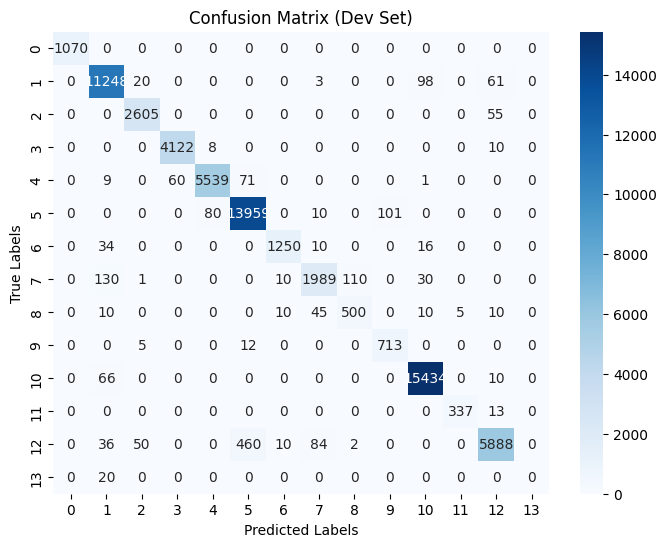

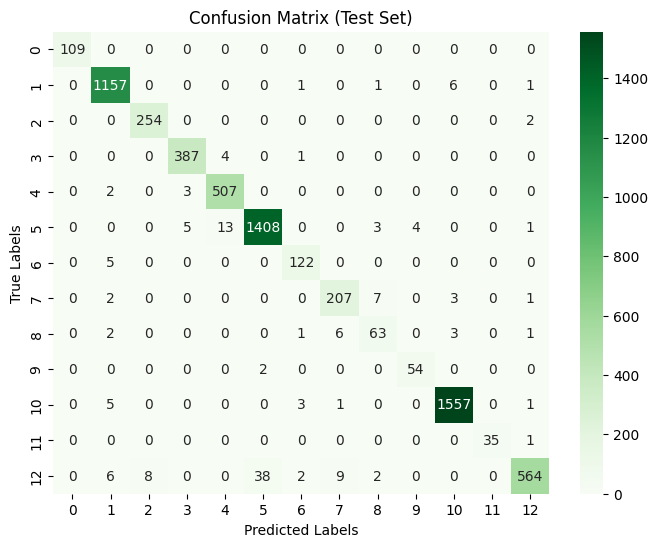

In [ ]:
from sklearn.metrics import confusion_matrix

dev_confusion_matrix = confusion_matrix(dev_targets_all, dev_predicted_all)

test_confusion_matrix = confusion_matrix(true_labels, predicted_labels)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(dev_confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix (Dev Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, cmap='Greens', fmt='g')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


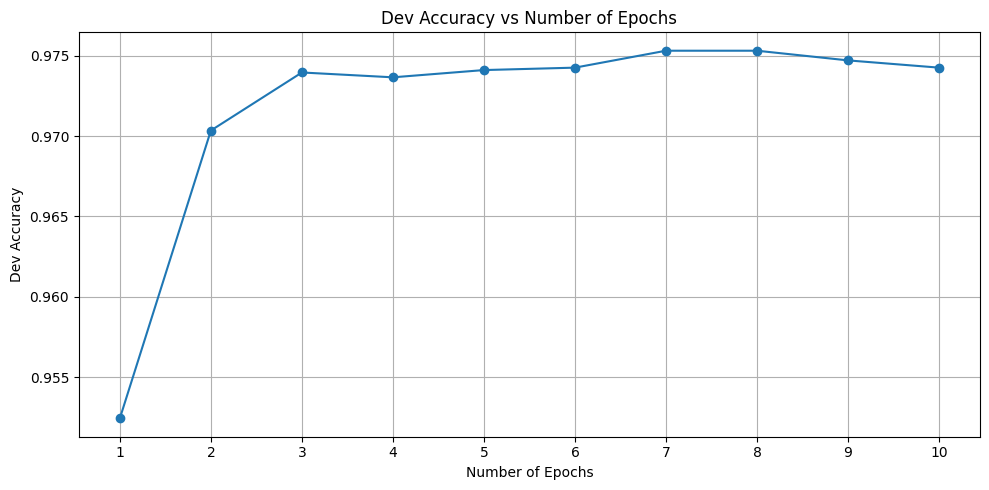

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

epochs = list(range(1, 11))  # Epochs from 1 to 10
dev_accuracy = [
    0.9524382901866345, 0.9703491872366045, 0.9739614689945816, 0.9736604455147502,
    0.9741119807344973, 0.974262492474413, 0.975316074653823, 0.975316074653823,
    0.9747140276941602, 0.974262492474413
]

df = pd.DataFrame(list(zip(epochs, dev_accuracy)), columns=['Epoch', 'Dev Accuracy'])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Dev Accuracy'], marker='o')
plt.title('Dev Accuracy vs Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Dev Accuracy')
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()


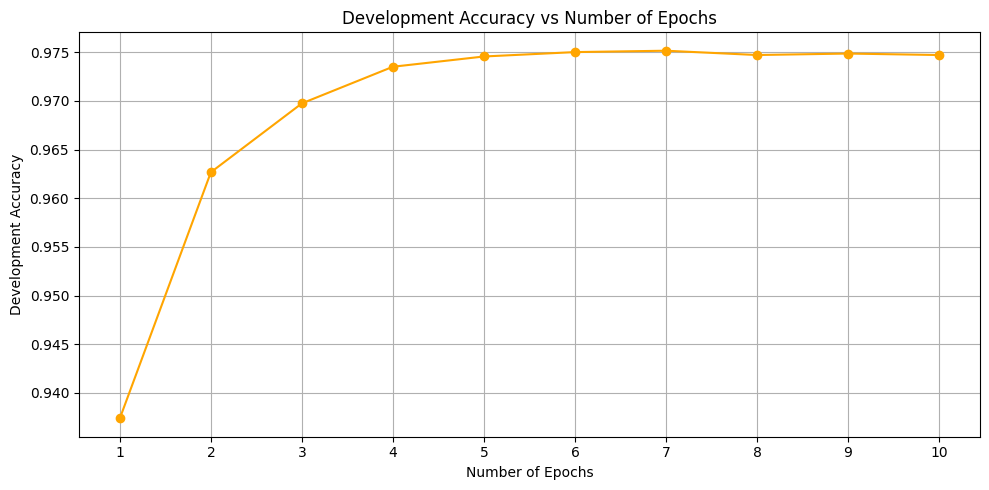

In [ ]:
dev_accuracy_2 = [
    0.9373886514148104, 0.9626730885009003, 0.9697471402769416, 0.9735099337748344,
    0.974563519542444, 0.9750150511739916, 0.975156529139073, 0.9747140276941602,
    0.9748645394340758, 0.9747140276941602
]

df_2 = pd.DataFrame(list(zip(epochs, dev_accuracy_2)), columns=['Epoch', 'Dev Accuracy'])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_2['Epoch'], df_2['Dev Accuracy'], marker='o', color='orange')
plt.title('Development Accuracy vs Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Development Accuracy')
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()



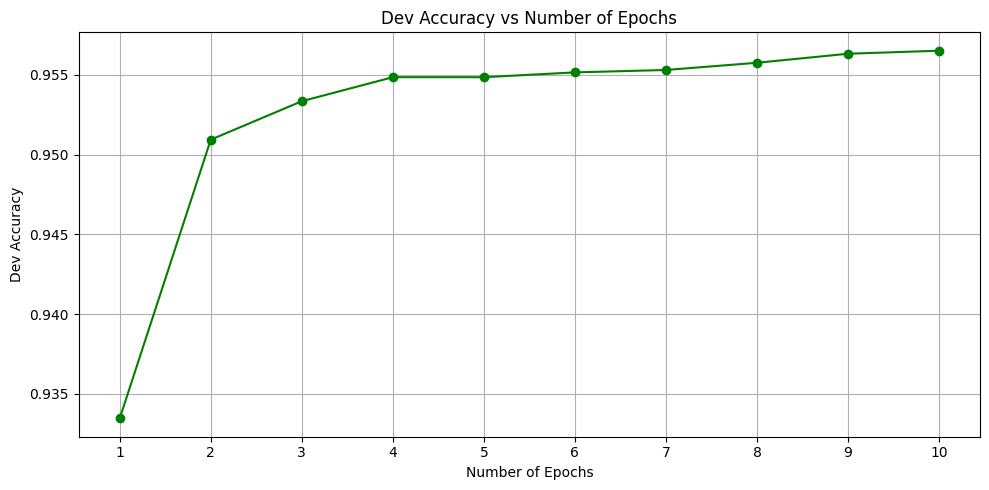

In [ ]:
dev_accuracy_3 = [
    0.9334738109572547, 0.9509331727874775, 0.9533413660621288, 0.954846478025286,
    0.954846478025286, 0.9551475015051174, 0.9552980132450332, 0.9557495484647802,
    0.9563155954244431, 0.9565050794461616
]

df_3 = pd.DataFrame(list(zip(epochs, dev_accuracy_3)), columns=['Epoch', 'Dev Accuracy'])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_3['Epoch'], df_3['Dev Accuracy'], marker='o', color='green')
plt.title('Dev Accuracy vs Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Dev Accuracy')
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()
